<a href="https://colab.research.google.com/github/deralph/car-prediction-model-kaggle-skill-assesment/blob/main/kaggleAssesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import iqr

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV,BayesianRidge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import re

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
test=pd.read_csv('test.csv',index_col='id')
train=pd.read_csv('train.csv',index_col='id')

In [ ]:
print(test.shape)
print(train.shape)

(36183, 11)
(54273, 12)


In [ ]:
train.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250


In [ ]:
train.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54273 entries, 0 to 54272
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         54273 non-null  object
 1   model         54273 non-null  object
 2   model_year    54273 non-null  int64 
 3   milage        54273 non-null  int64 
 4   fuel_type     54273 non-null  object
 5   engine        54273 non-null  object
 6   transmission  54273 non-null  object
 7   ext_col       54273 non-null  object
 8   int_col       54273 non-null  object
 9   accident      54273 non-null  object
 10  clean_title   54273 non-null  object
 11  price         54273 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 5.4+ MB


In [ ]:
columns=train.columns
columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [ ]:
train['clean_title'].value_counts()

clean_title
Yes    54273
Name: count, dtype: int64

In [ ]:
test['clean_title'].value_counts()

clean_title
Yes    36183
Name: count, dtype: int64

In [ ]:
train['accident'].value_counts()

accident
None reported                             39896
At least 1 accident or damage reported    14377
Name: count, dtype: int64

In [ ]:
train['accident']=train['accident'].apply(lambda x: 'None' if x=='None reported' else 'reported')


In [ ]:
train['accident'].value_counts()

accident
None        39896
reported    14377
Name: count, dtype: int64

In [ ]:
categorical_features = ['brand', 'model', 'fuel_type', 'engine', 'transmission','accident','ext_col','clean_title','int_col']


In [ ]:
for i in categorical_features:
    print(i)
    print(train[i].unique().shape)
    # print(train[i].value_counts())

brand
(53,)
model
(1827,)
fuel_type
(7,)
engine
(1061,)
transmission
(46,)
accident
(2,)
ext_col
(260,)
clean_title
(1,)
int_col
(124,)


In [ ]:
train['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

In [ ]:
test['fuel_type'].value_counts()

fuel_type
Gasoline          33033
Hybrid             1112
E85 Flex Fuel      1018
Diesel              671
–                   197
Plug-In Hybrid      148
not supported         4
Name: count, dtype: int64

In [ ]:
train['fuel_type']=train['fuel_type'].apply(lambda x: 'unknown' if (x=='–' or x=='not supported') else x)


In [ ]:
train['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
unknown             298
Plug-In Hybrid      182
Name: count, dtype: int64

In [ ]:
test.drop(columns=['clean_title','ext_col','int_col'],axis=1,inplace=True)

In [ ]:
train.drop(columns=['clean_title','ext_col','int_col'],axis=1,inplace=True)

In [ ]:
print(train['transmission'].value_counts())
# automatic , manual,dual,cvt,Overdrive Switch, unknown(-,scheduled),dct,Transmission Overdrive Switch,cvf-f,f

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

In [ ]:
def predictTransmissionMode(x):
  x=x.lower()
  if 'dual' in x or 'at/mt' in x:
    return 'dual'
  elif 'scheduled' in x or x=='–' :
    return 'unknown'
  elif 'm/t'in x or 'manual' in x :
    return 'manual'
  elif 'a/t' in x or 'automatic' in x or 'cvt' in x or x=='f'  or x=='variable':
    return 'automatic'

In [ ]:
train['transmissiom_mode']=train['transmission'].apply(predictTransmissionMode)

In [ ]:
train['transmissiom_mode'].value_counts()

transmissiom_mode
automatic    42879
dual          6455
manual        4864
unknown          9
Name: count, dtype: int64

In [ ]:
train['engine'].value_counts()

engine
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                    1452
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel                             1125
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                             1054
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel                             979
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                              893
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                             684
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel                             679
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                              592
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel                              583
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel                             570
335.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                     570
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel                     569
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            

In [ ]:
# Feature engineering on engine column

engine_df = pd.DataFrame()




# Feature extraction from engine  functions
def extract_engine_size(engine):
    match = re.search(r'(\d+(\.\d+)?)L', engine)
    return float(match.group(1)) if match else None

def extract_cylinders(engine):
    match = re.search(r'(\d+)\s+Cylinder', engine)
    return int(match.group(1)) if match else None

def extract_horsepower(engine):
    match = re.search(r'(\d+(\.\d+)?)HP', engine)
    return float(match.group(1)) if match else None

def extract_fuel_type(engine):
    if 'Electric' in engine or 'Battery' in engine:
        return 'Electric'
    elif 'Flex Fuel' in engine:
        return 'Flex Fuel'
    elif 'Gasoline' in engine:
        return 'Gasoline'
    else:
        return 'Unknown'

def extract_turbocharged(engine):
    return 'Turbo' in engine or 'Twin Turbo' in engine

def extract_configuration(engine):
    match = re.search(r'(Straight \d+|V\d+|I4|Flat \d+)', engine)
    return match.group(0) if match else None

def extract_valve_count(engine):
    match = re.search(r'(\d+)V', engine)
    return int(match.group(1)) if match else None

# Applying feature extraction
engine_df['Engine_Size_L'] = train['engine'].apply(extract_engine_size)
engine_df['Cylinder_Count'] = train['engine'].apply(extract_cylinders)
engine_df['Horsepower_HP'] = train['engine'].apply(extract_horsepower)
engine_df['Fuel_Type'] = train['engine'].apply(extract_fuel_type)
engine_df['Turbocharged'] = train['engine'].apply(extract_turbocharged)
engine_df['Engine_Configuration'] = train['engine'].apply(extract_configuration)
engine_df['Valve_Count'] = train['engine'].apply(extract_valve_count)

engine_df.head()

,Engine_Size_L,Cylinder_Count,Horsepower_HP,Fuel_Type,Turbocharged,Engine_Configuration,Valve_Count
id,,,,,,,
0,3.50,6.00,375.00,Gasoline,False,V6,NaN
1,3.00,6.00,300.00,Gasoline,False,Straight 6,NaN
2,4.20,8.00,300.00,Gasoline,False,None,NaN
3,3.00,6.00,335.00,Electric,False,Straight 6,NaN
4,3.80,6.00,200.00,Gasoline,False,V6,NaN


In [ ]:
train['engine'].head()

id
0        375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
1    300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
2         300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel
3    335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
4        200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel
Name: engine, dtype: object

In [ ]:
engine_df['Turbocharged'].value_counts()

Turbocharged
False    52405
True      1868
Name: count, dtype: int64

In [ ]:
engine_df['Turbocharged']=engine_df['Turbocharged'].apply(lambda x: 1 if x==True else 0)

In [ ]:
engine_df['Turbocharged'].value_counts()

Turbocharged
0    52405
1     1868
Name: count, dtype: int64

In [ ]:
engine_df['Fuel_Type'].value_counts()

Fuel_Type
Gasoline     45521
Unknown       5103
Electric      2163
Flex Fuel     1486
Name: count, dtype: int64

In [ ]:
null_values=engine_df.isna().sum()
null_percentages = engine_df.isnull().mean() * 100
print('null values = \n ',null_values,'\n')
print('percentage = \n',null_percentages)

null values = 
  Engine_Size_L             606
Cylinder_Count           4175
Horsepower_HP            4057
Fuel_Type                   0
Turbocharged                0
Engine_Configuration    28461
Valve_Count             50738
dtype: int64 

percentage = 
 Engine_Size_L           1.12
Cylinder_Count          7.69
Horsepower_HP           7.48
Fuel_Type               0.00
Turbocharged            0.00
Engine_Configuration   52.44
Valve_Count            93.49
dtype: float64


In [ ]:
# Handling null values
engine_df.drop(columns=['Valve_Count','Fuel_Type'],axis=1,inplace=True)

In [ ]:
engine_df['Engine_Size_L'].fillna(engine_df['Engine_Size_L'].mean(), inplace=True)
engine_df['Cylinder_Count'].fillna(engine_df['Cylinder_Count'].median(), inplace=True)
engine_df['Horsepower_HP'].fillna(engine_df['Horsepower_HP'].mean(), inplace=True)
engine_df['Engine_Configuration'].fillna('Unknown', inplace=True)


In [ ]:
engine_df['Engine_Configuration'].value_counts()

Engine_Configuration
Unknown       28461
V6            17228
Straight 6     5106
Flat 6         1437
I4             1022
V8              934
V12              64
V10              21
Name: count, dtype: int64

In [ ]:
def classifyEngineConfig(x):
  if 'Straight' in x:
    return 'Straight'
  elif 'V' in x:
    return 'V'
  elif 'I4' in x:
    return 'I4'
  elif 'Flat' in x:
    return 'Flat'
  else:
    return x

In [ ]:
engine_df['Engine_Configuration']=engine_df['Engine_Configuration'].apply(classifyEngineConfig)

In [ ]:
engine_df['Engine_Configuration'].value_counts()

Engine_Configuration
Unknown     28461
V           18247
Straight     5106
Flat         1437
I4           1022
Name: count, dtype: int64

In [ ]:
engine_df.isna().sum()

Engine_Size_L           0
Cylinder_Count          0
Horsepower_HP           0
Turbocharged            0
Engine_Configuration    0
dtype: int64

In [ ]:
engine_df.head()

,Engine_Size_L,Cylinder_Count,Horsepower_HP,Turbocharged,Engine_Configuration
id,,,,,
0,3.50,6.00,375.00,0,V
1,3.00,6.00,300.00,0,Straight
2,4.20,8.00,300.00,0,Unknown
3,3.00,6.00,335.00,0,Straight
4,3.80,6.00,200.00,0,V


In [ ]:
train=pd.concat([train,engine_df],axis=1)

In [ ]:
train.drop('engine',axis=1,inplace=True)

In [ ]:
train.head(1)

,brand,model,model_year,milage,fuel_type,transmission,accident,price,transmissiom_mode,Engine_Size_L,Cylinder_Count,Horsepower_HP,Turbocharged,Engine_Configuration
id,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,10-Speed A/T,None,11000,automatic,3.50,6.00,375.00,0,V


In [ ]:
train.drop('transmission',axis=1,inplace=True)

In [ ]:
train.rename(columns={'transmissiom_mode':'transmission_mode'},inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 54273 non-null  object 
 1   model                 54273 non-null  object 
 2   model_year            54273 non-null  int64  
 3   milage                54273 non-null  int64  
 4   fuel_type             54273 non-null  object 
 5   accident              54273 non-null  object 
 6   price                 54273 non-null  int64  
 7   transmission_mode     54207 non-null  object 
 8   Engine_Size_L         54273 non-null  float64
 9   Cylinder_Count        54273 non-null  float64
 10  Horsepower_HP         54273 non-null  float64
 11  Turbocharged          54273 non-null  int64  
 12  Engine_Configuration  54273 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 5.8+ MB


In [ ]:
for i in ['brand','model'] :
    print(i)
    print(train[i].value_counts(),'/n/n')

brand
brand
BMW              7369
Ford             6706
Mercedes-Benz    5087
Chevrolet        4424
Audi             2922
Porsche          2627
Toyota           2315
Lexus            2257
Jeep             2247
Land             1995
Cadillac         1565
Nissan           1252
GMC              1076
Dodge            1011
RAM               966
INFINITI          957
Lincoln           767
Mazda             748
Subaru            739
Hyundai           694
Jaguar            661
Volkswagen        628
Honda             624
Acura             580
Kia               526
Volvo             452
MINI              364
Maserati          293
Bentley           284
Chrysler          258
Genesis           249
Buick             228
Mitsubishi        182
Hummer            176
Pontiac           149
Alfa              144
Rolls-Royce       142
Lamborghini       122
Tesla             110
Ferrari            87
Saturn             58
Scion              53
Aston              50
McLaren            43
Rivian             2

In [ ]:
# Target encoding for brand and model
train['brand_encoded'] = train.groupby('brand')['price'].transform('mean')
train['model_encoded'] = train.groupby('model')['price'].transform('mean')


In [ ]:
train.head(2)

,brand,model,model_year,milage,fuel_type,accident,price,transmission_mode,Engine_Size_L,Cylinder_Count,Horsepower_HP,Turbocharged,Engine_Configuration,brand_encoded,model_encoded
id,,,,,,,,,,,,,,,
0,Ford,F-150 Lariat,2018,74349,Gasoline,None,11000,automatic,3.50,6.00,375.00,0,V,38154.06,43169.96
1,BMW,335 i,2007,80000,Gasoline,None,8250,manual,3.00,6.00,300.00,0,Straight,40276.03,15520.38


In [ ]:
train['brand_encoded'].unique().shape

(53,)

In [ ]:
train['model_encoded'].unique().shape

(1816,)

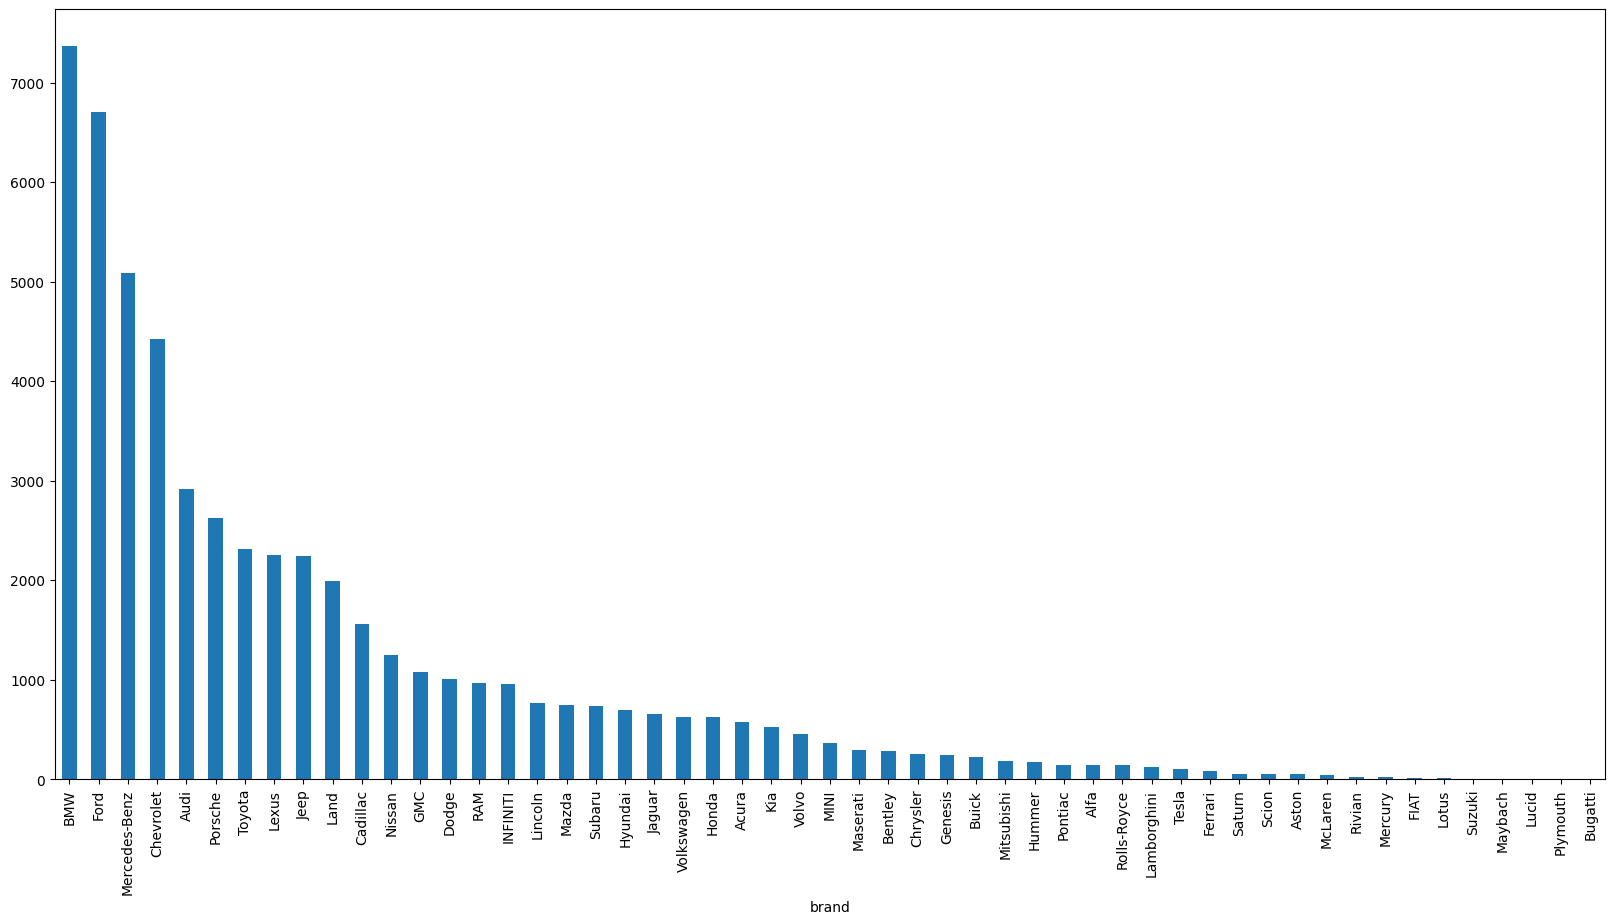

In [ ]:
train['brand'].value_counts().plot(kind='bar',figsize=(20,10),stacked=False)
plt.show()

In [ ]:
train['model_year'].value_counts()

KeyError: 0

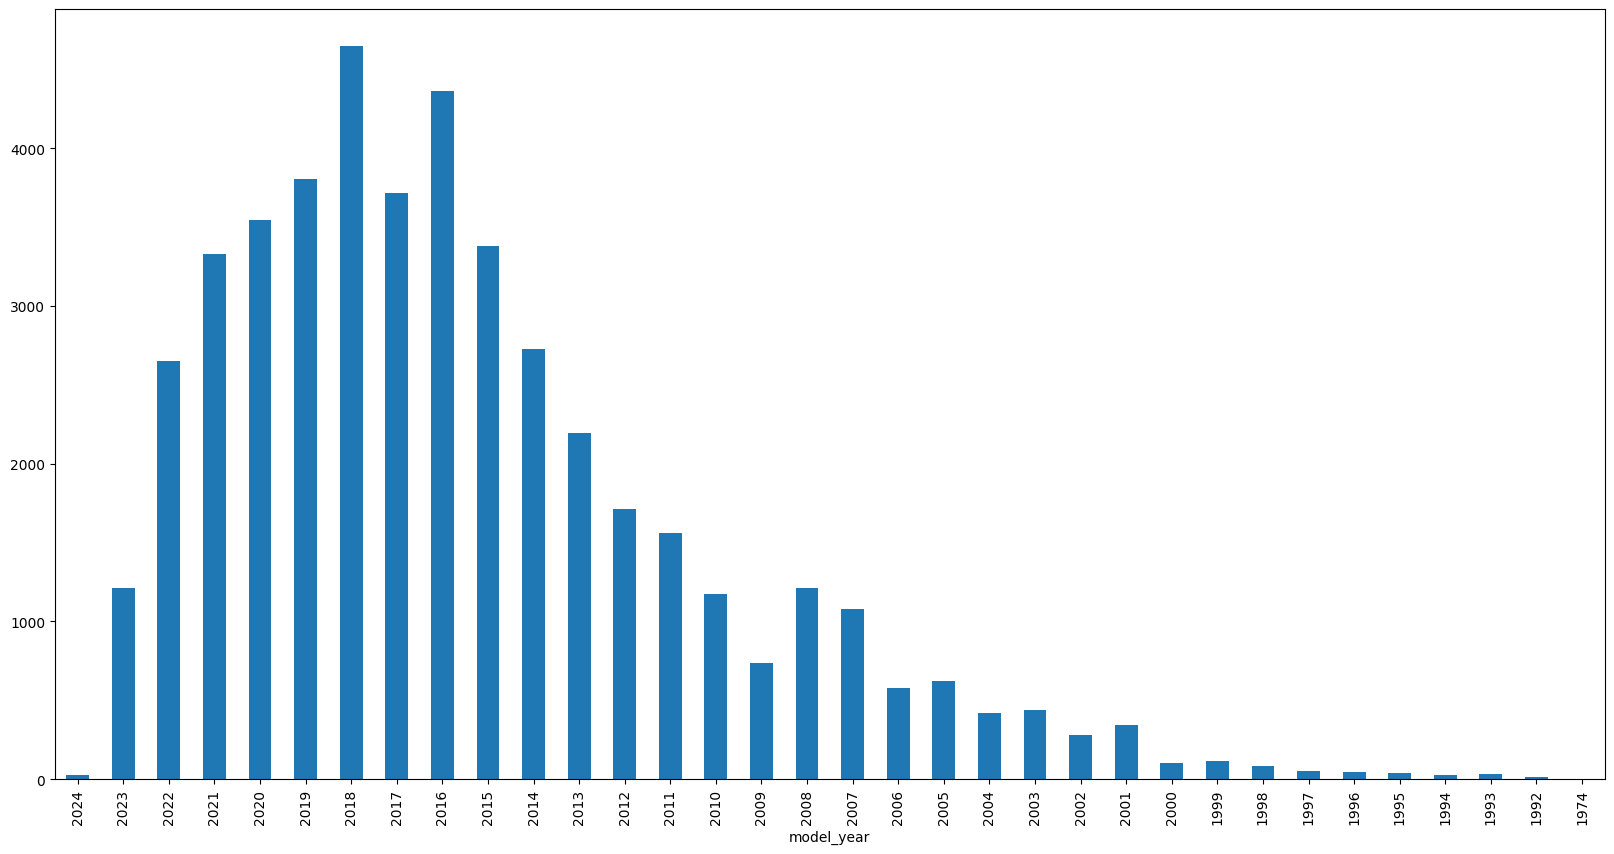

In [ ]:
train['model_year'].value_counts().sort_index(ascending=False).plot(kind='bar',figsize=(20,10),stacked=False)
plt.show()

In [ ]:
train.drop(columns=['brand','model'],axis=1,inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54273 entries, 0 to 54272
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model_year            54273 non-null  int64  
 1   milage                54273 non-null  int64  
 2   fuel_type             54273 non-null  object 
 3   accident              54273 non-null  object 
 4   price                 54273 non-null  int64  
 5   transmission_mode     54207 non-null  object 
 6   Engine_Size_L         54273 non-null  float64
 7   Cylinder_Count        54273 non-null  float64
 8   Horsepower_HP         54273 non-null  float64
 9   Turbocharged          54273 non-null  int64  
 10  Engine_Configuration  54273 non-null  object 
 11  brand_encoded         54273 non-null  float64
 12  model_encoded         54273 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 5.8+ MB


<Axes: >

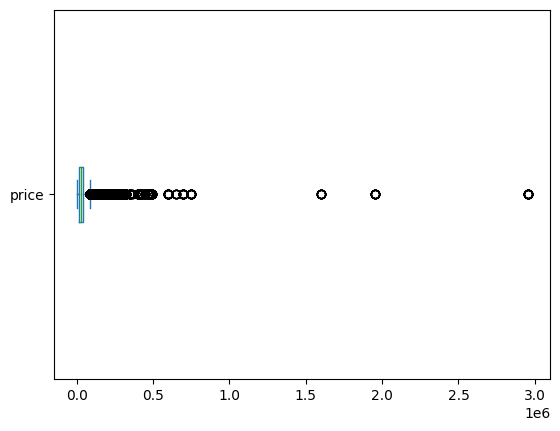

In [ ]:
train['price'].plot(kind='box',vert=False)

Text(0.5, 1.0, 'Car Price Distribution Plot')

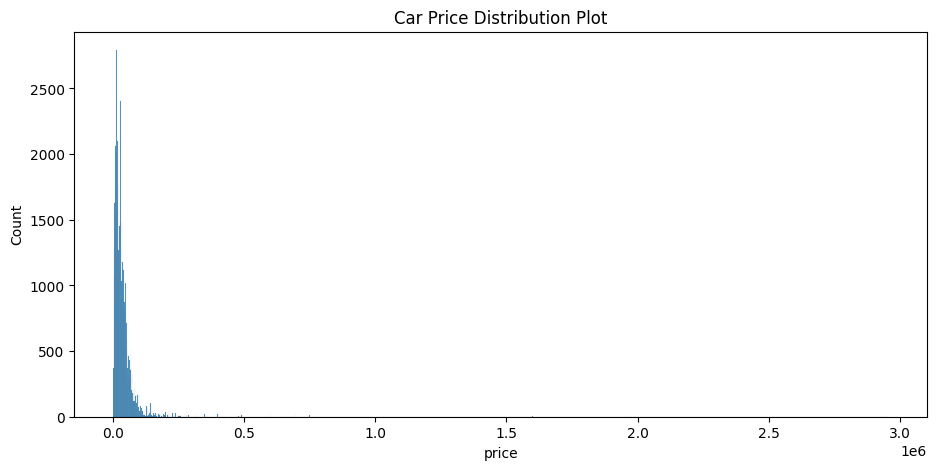

In [ ]:
# This makes it very easy to spot anomalies, such as outliers
plt.figure(figsize=[11,5])
sns.histplot(train['price'])
plt.title('Car Price Distribution Plot')

<Axes: >

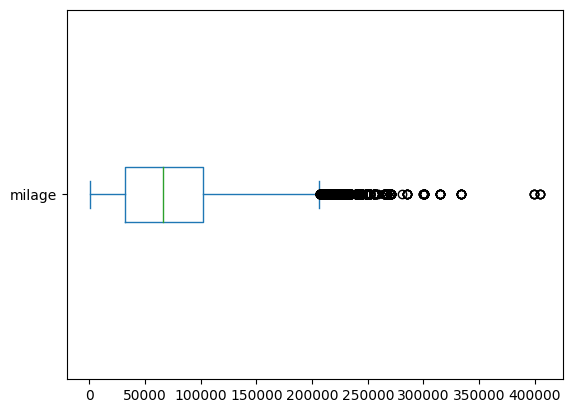

In [ ]:
train['milage'].plot(kind='box',vert=False)

In [ ]:
price_iqr=iqr(train['price'])
q1,q3=np.quantile(train['price'],[0.25,0.75])

train.loc[train['price']<q1-1.5*price_iqr,'price']=np.nan
train.loc[train['price']>q3+1.5*price_iqr,'price']=np.nan

# train = train[(train['price'] >= q3+1.5*price_iqr) & (train['price'] <= q1-1.5*price_iqr)]
train.isna().sum()

model_year                 0
milage                     0
fuel_type                  0
accident                   0
price                   3097
transmission_mode         66
Engine_Size_L              0
Cylinder_Count             0
Horsepower_HP              0
Turbocharged               0
Engine_Configuration       0
brand_encoded              0
model_encoded              0
dtype: int64

In [ ]:
train.dropna(inplace=True)
train.shape

(51116, 13)

<Axes: >

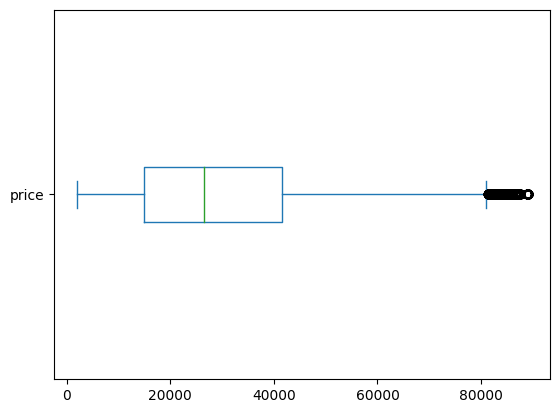

In [ ]:
train['price'].plot(kind='box',vert=False)

<ipython-input-62-846f12fc8c65>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['price'])


Text(0.5, 1.0, 'Car Price Distribution Plot')

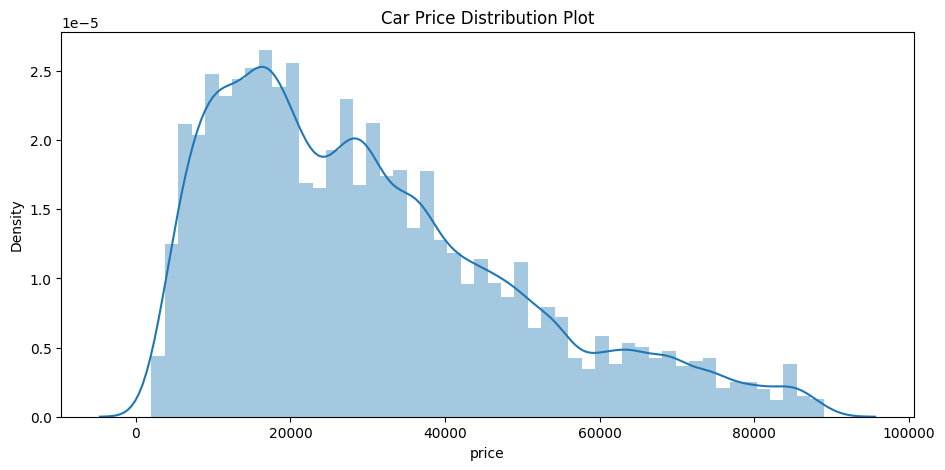

In [ ]:
# This makes it very easy to spot anomalies, such as outliers
plt.figure(figsize=[11,5])
sns.distplot(train['price'])
plt.title('Car Price Distribution Plot')

<Axes: >

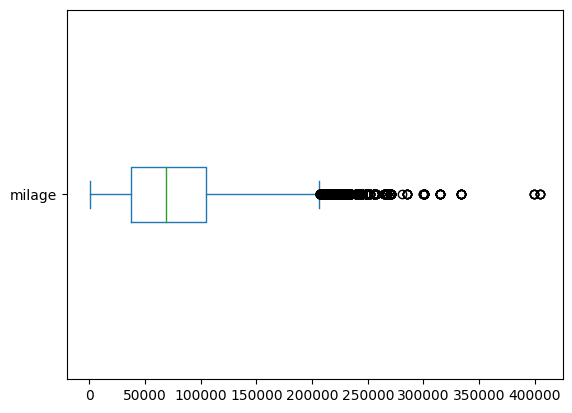

In [ ]:
train['milage'].plot(kind='box',vert=False)

In [ ]:
milage_igr=iqr(train['milage'])
train=train[(train['milage'] <= q3+1.5*milage_igr) & (train['milage'] >= q1-1.5*milage_igr)]
train.shape

(46260, 13)

<Axes: >

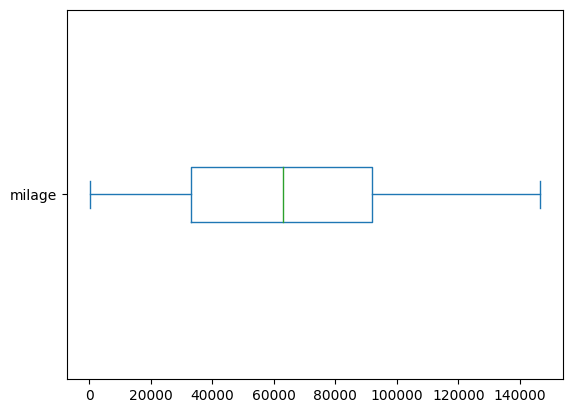

In [ ]:
train['milage'].plot(kind='box',vert=False)

<Axes: title={'center': 'Price and Milage'}, xlabel='price', ylabel='milage'>

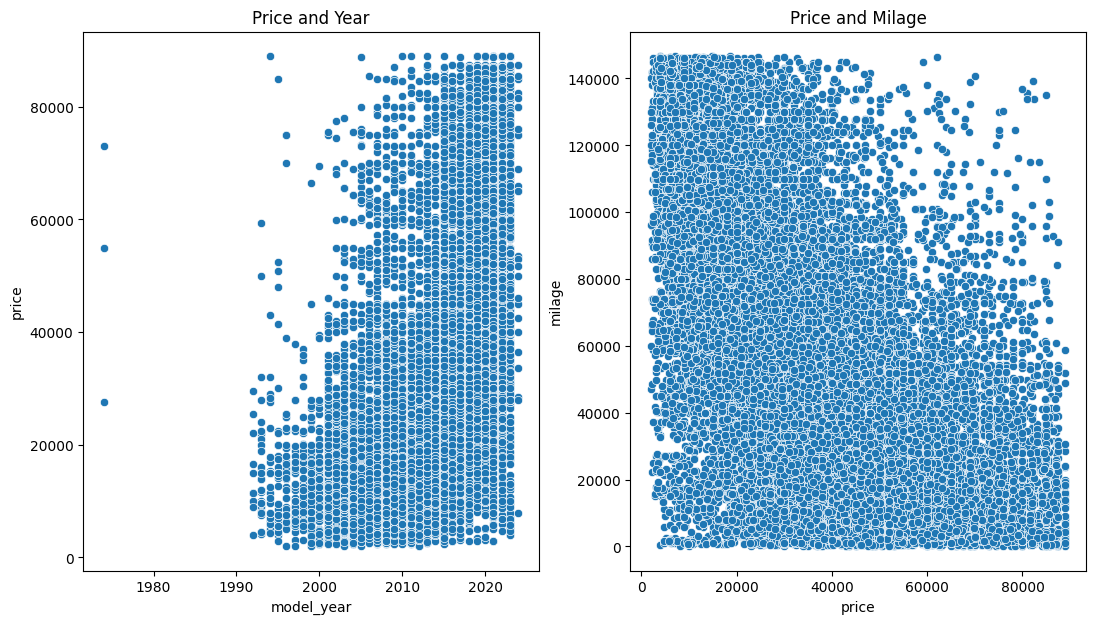

In [ ]:
# lets check the linearity using a scatter plot
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='model_year',y='price',data=train)

plt.subplot(1,3,2)
plt.title("Price and Milage")
sns.scatterplot(x='price',y='milage',data=train)



In [ ]:
# train['engine'].value_counts().plot(kind='bar',figsize=(20,10),stacked=False)


In [ ]:
train = pd.get_dummies(train, columns=['accident','fuel_type','transmission_mode','Engine_Configuration'], drop_first=True,dtype=int)


In [ ]:
train.head()

,model_year,milage,price,Engine_Size_L,Cylinder_Count,Horsepower_HP,Turbocharged,brand_encoded,model_encoded,accident_reported,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_unknown,transmission_mode_dual,transmission_mode_manual,transmission_mode_unknown,Engine_Configuration_I4,Engine_Configuration_Straight,Engine_Configuration_Unknown,Engine_Configuration_V
id,,,,,,,,,,,,,,,,,,,,,,
0,2018,74349,11000.00,3.50,6.00,375.00,0,38154.06,43169.96,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2007,80000,8250.00,3.00,6.00,300.00,0,40276.03,15520.38,0,0,1,0,0,0,0,1,0,0,1,0,0
2,2009,91491,15000.00,4.20,8.00,300.00,0,34840.40,14397.05,0,0,1,0,0,0,0,0,0,0,0,1,0
3,2022,2437,63500.00,3.00,6.00,335.00,0,40276.03,68657.68,0,0,0,1,0,0,1,0,0,0,1,0,0
4,2001,111000,7850.00,3.80,6.00,200.00,0,17526.06,10793.00,0,0,1,0,0,0,0,0,0,0,0,0,1


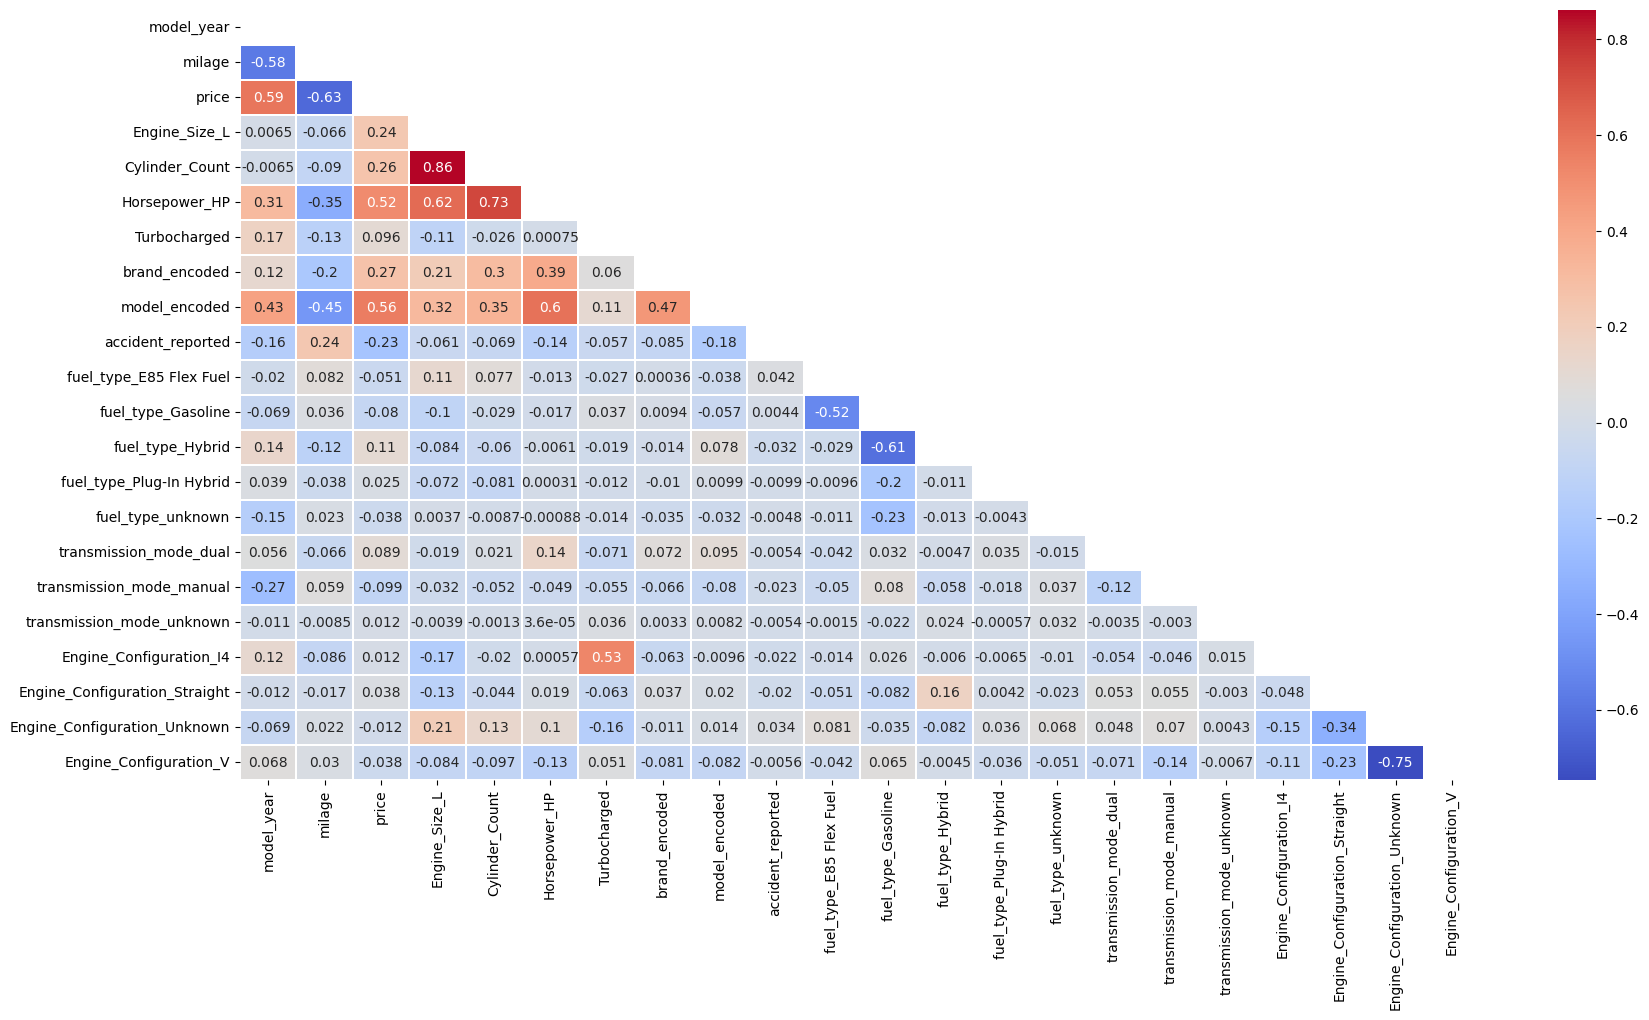

In [ ]:
plt.figure(figsize=(20,10))
mask= np.triu(np.ones_like(train.corr(), dtype = bool))
sns.heatmap(train.corr(),annot=True,cmap='coolwarm',linewidth=0.1,mask=mask)
plt.show()

In [ ]:
train.drop('Cylinder_Count',axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
temp_data = train.copy()
for col in temp_data.columns:
    if temp_data[col].dtypes == 'object':
        encoder = LabelEncoder()
        temp_data[col] = encoder.fit_transform(temp_data[col])

# Correated Features with target variable
print('\n--Correated Features with target variable--\n')
print(abs(temp_data.corrwith(temp_data['price'])).sort_values(ascending=False)[1:])


--Correated Features with target variable--

milage                          0.63
model_year                      0.59
model_encoded                   0.56
Horsepower_HP                   0.52
brand_encoded                   0.27
Engine_Size_L                   0.24
accident_reported               0.23
fuel_type_Hybrid                0.11
transmission_mode_manual        0.10
Turbocharged                    0.10
transmission_mode_dual          0.09
fuel_type_Gasoline              0.08
fuel_type_E85 Flex Fuel         0.05
Engine_Configuration_Straight   0.04
Engine_Configuration_V          0.04
fuel_type_unknown               0.04
fuel_type_Plug-In Hybrid        0.02
Engine_Configuration_Unknown    0.01
transmission_mode_unknown       0.01
Engine_Configuration_I4         0.01
dtype: float64


In [ ]:
train.shape

(46260, 21)

In [ ]:
# plt.figure(figsize=(10,6))
# mask = np.triu(np.ones_like(train.corr(), dtype = bool))
# sns.heatmap(train.corr(),annot=True,mask=mask,cmap='coolwarm',linewidth=0.1)

In [ ]:
X=train.drop('price',axis=1)
y=train['price']

In [ ]:
test.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,accident
id,,,,,,,,
54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,None reported
54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,None reported
54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,None reported
54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,At least 1 accident or damage reported
54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,At least 1 accident or damage reported


In [ ]:
test.shape

(36183, 8)

In [ ]:
# for col in X.columns:
    # if col not in test.columns:
        # X.drop(col,axis=1,inplace=True)
        # print(col)

In [ ]:
X.shape

(46260, 20)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1111)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
ExtraTreemodel = ExtraTreesRegressor()
ExtraTreemodel.fit(X,y)
y_extratree_pred=ExtraTreemodel.predict(X_test)
r2 = r2_score(y_test, y_extratree_pred)
print('R2 score:', r2)

R2 score: -0.9806890312709651


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


In [ ]:
model=RandomForestRegressor(random_state=1111,n_estimators=100)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)

R2 score: 0.5821381569766273


In [ ]:
print(model.score(X_test,y_test))

0.5847318437187146


In [ ]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}')


KeyboardInterrupt: 

In [ ]:
importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

In [ ]:
y_test_pred=model.predict(test)
print(y_test_pred)

In [ ]:
# GBT Regressor Model
# Model Building
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor()

# Training Model
gbt.fit(X_train,y_train)

# Model Summary
y_pred_gbt = gbt.predict(X_test)

r_squared = r2_score(y_test,y_pred_gbt)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_gbt))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.6185484666082631
RMSE : 11880.336010398913


In [ ]:
# submision=pd.DataFrame({'id':test.index,'price':y_test_pred})
# submision.to_csv('submission.csv',index=False)
# submision.head()

In [ ]:
mse= mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
print(rmse)

In [ ]:
linearModel=LinearRegression()
linearModel.fit(X_train,y_train)
y_linear_pred=linearModel.predict(X_test)
r2 = r2_score(y_test, y_linear_pred)
print('R2 score:', r2)

In [ ]:
acuracy = linearModel.score(X_test,y_test)
print(acuracy)

In [ ]:
mse= mean_squared_error(y_test,y_linear_pred)
print(mse)

In [ ]:
rmse=np.sqrt(mse)
print(rmse)

In [ ]:
regressors = [
    ('bayesian ridge', BayesianRidge()),
    ('elastic net',ElasticNetCV()),
    ('linear_reg', LinearRegression()),
    ('lasso',LassoCV()),
    ('ridge',RidgeCV())
]

In [ ]:
evals = {}




for clf, model in regressors:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    mse= mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    evals[clf] = [score,rmse,mse]

In [ ]:
for key,value in evals.items():
    print(key,' = ',value)

In [ ]:

evals_df = pd.DataFrame({'model':evals.keys(),'r2_score':evals.values()})
evals_df.sort_values('r2_score', inplace = True)
evals_df


In [ ]:
# Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

rf = RandomForestRegressor()


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)
print(rf_random.best_params_)
predictions=rf_random.predict(X_test)
r_squared = r2_score(y_test,predictions)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print("R_squared :",r_squared)



{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  18.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  18.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  18.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  17.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=  17.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  23.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  23.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  22.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  22.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  39.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  40.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  39.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  41.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=  41.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=700; total time= 1.1min
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  53.8s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  56.1s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  49.9s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  49.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  48.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  13.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1100; total time=  13.4s
[CV] END max_depth=5, max_feat

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time= 1.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=700; total time= 1.4min
{'n_estimators': 1100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
R_squared : 0.6280193498260136
